# Proyecto final - Luis G

- Enlace al Drive: https://drive.google.com/drive/folders/1eVDh31eZ0zU3M7SHic-7-tgXja4gU7Ry?usp=sharing
- Enlace al Dashboard: https://public.tableau.com/app/profile/luis.gutierrez2670/viz/Dashboard_17469899994240/Dashboard1#2

In [59]:
# Importar librerias

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import levene

In [60]:
# Importar datasets

df_calls = pd.read_csv('telecom_dataset_us.csv')
df_clients = pd.read_csv('telecom_clients_us.csv')

## Análisis inicial

In [61]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [62]:
df_calls.sample(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
9385,166658,2019-10-29 00:00:00+03:00,out,False,890410.0,True,4,0,138
53812,168601,2019-11-04 00:00:00+03:00,out,False,952914.0,False,2,68,96
21587,167035,2019-10-29 00:00:00+03:00,in,False,NaN,True,5,0,47
8425,166658,2019-09-12 00:00:00+03:00,out,False,891160.0,False,2,512,565
21198,167016,2019-11-25 00:00:00+03:00,out,False,962902.0,False,30,1038,1581


- Valores ausentes en internal y id de operador
- Cambiar columna de date a datatime
- Extraer mes, año y/o día según la temporalidad de los datos
- Extraer la diferencia entre la duración de la llamada y el tiempo total de la llamada, para saber el tiempo de espera antes de contestar
- El id de operador podría ser datatype int, pero seguro por los valores ausentes se coloca como float
- Columna internal podria ser tipo bool

In [63]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [64]:
df_clients.sample(5)

,user_id,tariff_plan,date_start
597,167115,B,2019-09-02
4,168193,A,2019-10-16
699,167384,B,2019-09-13
531,168315,B,2019-10-21
88,168185,C,2019-10-16


- Cambiar columna date_start a datatime

## Preprocesamiento de datos

### Dataframe calls

In [65]:
# Columna date

df_calls['date'] = pd.to_datetime(df_calls['date']).dt.tz_localize(None)

# Valores ausentes internal

df_calls[df_calls['internal'].isna()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18,in,NaN,NaN,True,1,0,59
1090,166405,2019-10-01,in,NaN,NaN,True,1,0,1
1864,166406,2019-08-20,in,NaN,NaN,True,1,0,36
1924,166406,2019-09-02,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26,in,NaN,908960.0,False,1,393,423
...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09,in,NaN,NaN,True,6,0,14
52590,168361,2019-11-13,in,NaN,NaN,True,2,0,6
52621,168361,2019-11-14,in,NaN,NaN,True,1,0,2
53717,168579,2019-11-09,in,NaN,NaN,True,1,0,18


- Quitaremos las 117 filas que no tienen valor en la columna internal

In [66]:
df_calls = df_calls[df_calls['internal'].notna()].reset_index(drop=True)

# Revisar operator id con valores ausentes

df_calls[df_calls['operator_id'].isna()]


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
7,166377,2019-08-05,in,False,NaN,True,6,0,35
9,166377,2019-08-06,in,False,NaN,True,4,0,62
17,166377,2019-08-07,in,False,NaN,True,2,0,24
27,166377,2019-08-12,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53759,168601,2019-11-27,in,False,NaN,True,2,0,39
53763,168601,2019-11-28,in,False,NaN,True,1,0,19
53772,168603,2019-11-28,in,False,NaN,True,1,0,30
53776,168606,2019-11-08,in,False,NaN,True,6,0,121


- Dado a que estamos evaluando el rendimiento de los operadores y estas filas no tienen a un operador vinculado, tendremos que quitar todas estas filas, no tiene caso conservarlas y pienso que podrian llegar a sesgar nuestros datos.

In [67]:
df_calls = df_calls[df_calls['operator_id'].notna()].reset_index(drop=True)

In [68]:
# Cambiar columna internal a bool

df_calls['internal'] = df_calls['internal'].astype(bool)

# Cambiar columna operator_id a int

df_calls['operator_id'] = df_calls['operator_id'].astype(int)

# Extraer columnas de date segun la granularidad de los datos

df_calls['date'].describe()

count                            45670
mean     2019-10-23 16:08:16.290781696
min                2019-08-02 00:00:00
25%                2019-10-06 00:00:00
50%                2019-10-28 00:00:00
75%                2019-11-14 00:00:00
max                2019-11-28 00:00:00
Name: date, dtype: object

- Vemos que los datos van desde el mes de agosto hasta el mes de noviembre, entonces separaremos de la columna date el mes y el día nada más

In [69]:
df_calls['month'] = df_calls['date'].dt.month
df_calls['day'] = df_calls['date'].dt.day

- Sacaremos el tiempo de espera promedio para las llamadas que sí enlazan. Las llamadas que no enlazan, harán que haya valores negativos en esta columna que introduciremos

In [70]:
# Función para la columna de tiempo de espera promedio

def waitingTime(row):
    if not row['is_missed_call']:
        waiting = (row['total_call_duration'] - row['call_duration']) / row['calls_count']

    else:
        waiting = np.nan

    return waiting

df_calls['avg_waiting_time'] = df_calls.apply(waitingTime, axis=1).round(2)

df_calls.sample(6)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month,day,avg_waiting_time
6304,166604,2019-10-13,in,False,893402,False,1,28,40,10,13,12.00
13297,166901,2019-11-28,out,False,896016,False,16,1727,1844,11,28,7.31
14501,166916,2019-11-27,out,False,906404,False,15,1787,1959,11,27,11.47
30195,167551,2019-10-07,out,True,919218,False,1,980,993,10,7,13.00
1757,166406,2019-09-27,out,False,879898,True,47,0,1026,9,27,NaN
44080,168361,2019-10-26,out,False,945286,True,141,0,2342,10,26,NaN


### Dataframe clients

In [71]:
# Cambiar columna date a datetime

df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

df_clients

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


## Análisis

### Análisis inicial

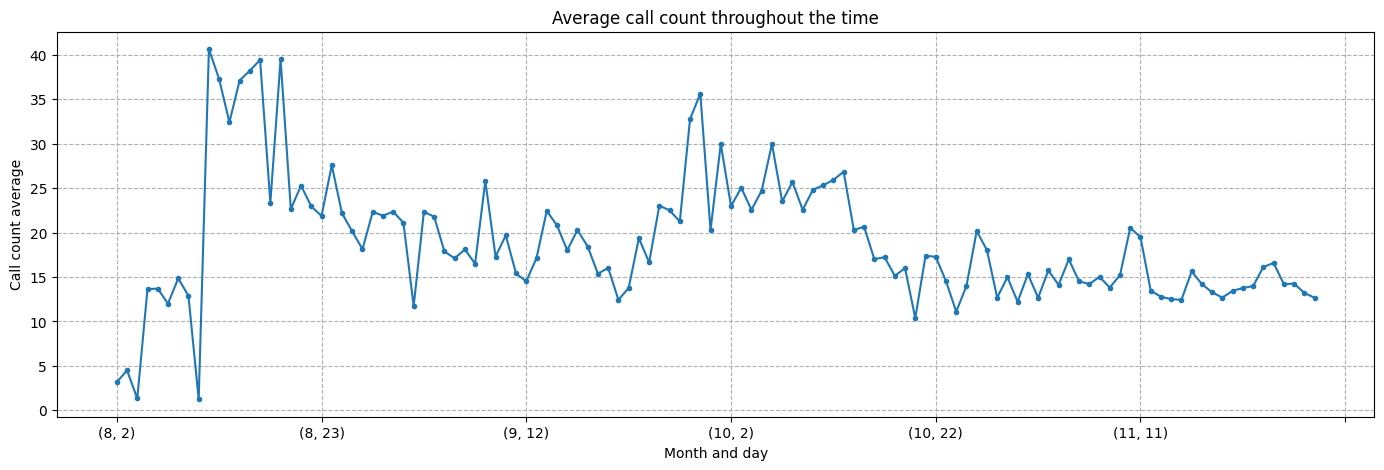

In [72]:
# Promedio de flujo de llamadas en general por fecha

total_calls_intime = df_calls.groupby(['month','day']).agg(call_count = ('calls_count','mean'))

total_calls_intime.plot(kind='line',figsize=(17,5), marker='.', legend=False)

plt.grid(linestyle='--')
plt.xlabel('Month and day')
plt.ylabel('Call count average')
plt.title('Average call count throughout the time')
plt.show()

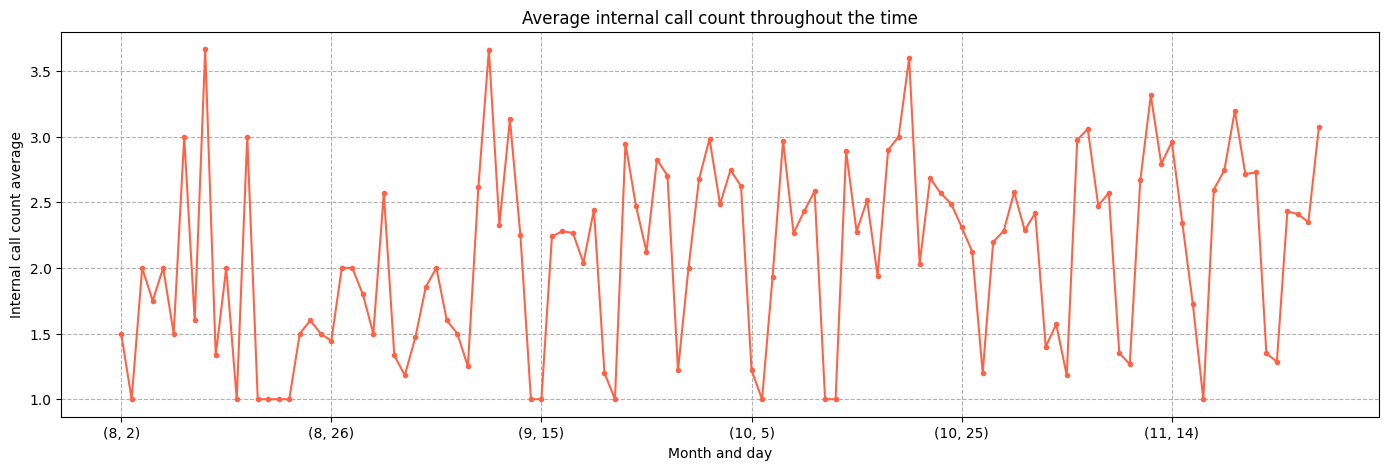

In [73]:
# Flujo de llamadas internas a lo largo del tiempo

internal_calls_intime = df_calls.query('internal == True')

internal_calls_intime = internal_calls_intime.groupby(['month','day']).agg(call_count = ('calls_count','mean'))

internal_calls_intime.plot(kind='line',figsize=(17,5), marker='.', legend=False, color='tomato')

plt.grid(linestyle='--')
plt.xlabel('Month and day')
plt.ylabel('Internal call count average')
plt.title('Average internal call count throughout the time')
plt.show()


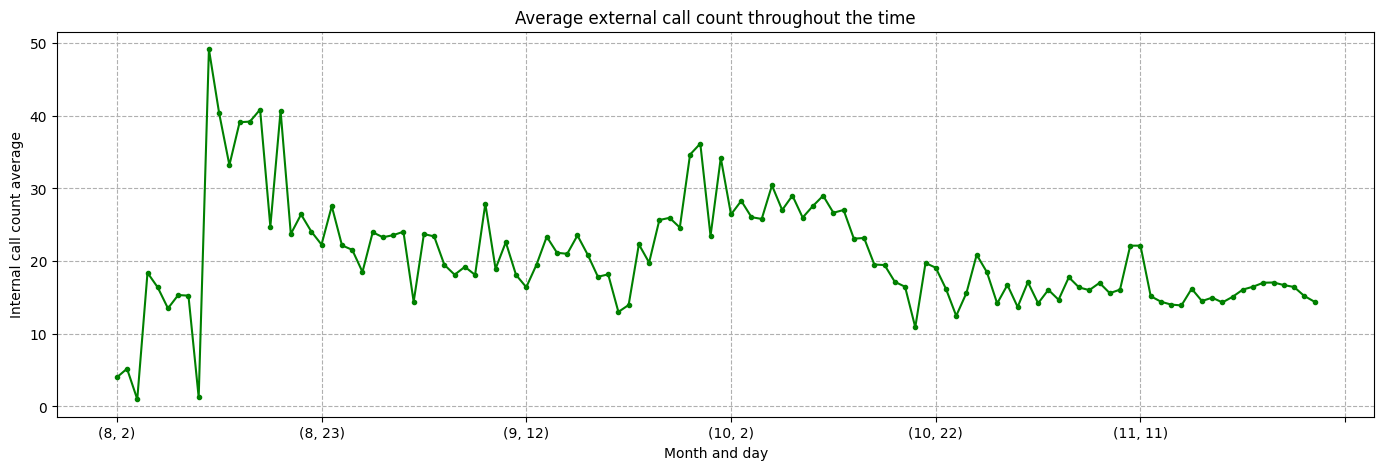

In [74]:
# Flujo de llamadas externas a lo largo del tiempo

external_calls_intime = df_calls.query('internal == False')

external_calls_intime = external_calls_intime.groupby(['month','day']).agg(call_count = ('calls_count','mean'))

external_calls_intime.plot(kind='line',figsize=(17,5), marker='.', legend=False, color='green')

plt.grid(linestyle='--')
plt.xlabel('Month and day')
plt.ylabel('Internal call count average')
plt.title('Average external call count throughout the time')
plt.show()


    - Con estos gráficos observamos que en general se manejan muchas más llamadas externas que llamadas internas, es de esperar de un centro de telecomunicaciones que esto suceda.
    - Tenemos picos de actividad a mitades de agosto y a inicios de octubre, no tenemos más referencia de por qué podría ser pero conservaremos ese dato en nuestra memoria.

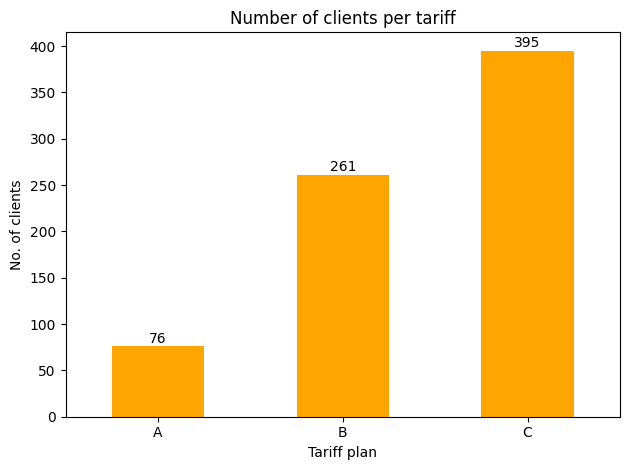

In [75]:
# Conteo de clientes por tarifa

clients_per_tariff = df_clients.groupby('tariff_plan').agg(no_clients = ('user_id','nunique')).reset_index()

clients_per_tariff.columns = ['tariff_plan', 'no_clients']

clients_per_tariff.plot(kind='bar', x='tariff_plan', y='no_clients', legend=False, rot=0, color='orange')

for idx, value in enumerate(clients_per_tariff['no_clients']):
    plt.text(idx, value + 0.5, str(value), ha='center', va='bottom')

plt.title('Number of clients per tariff')
plt.xlabel('Tariff plan')
plt.ylabel('No. of clients')
plt.tight_layout()
plt.show()

    - Vemos que el plan más popular es el plan C, veamos si podemos descrifrar qué tiene de especial en cuanto al rendimiento en llamadas.

- Dividiremos el análisis según el plan tarifario, ya que podrían haber diferentes rendimientos según el objetivo de cada empresa/su plan contratado.

In [76]:
# Verificar si no tenemos clientes con user id repetido antes del merge

df_clients['user_id'].duplicated().sum() # Devuelve 0


np.int64(0)

In [77]:
# Merge de ambos dataframes para comprobar si según el cliente/tarifa, varía la actividad de sus operadores (si se esperan más llamadas de entrada o de salida, por ejemplo)

df_merged = df_calls.merge(df_clients, on = 'user_id', how='left')

df_merged_A = df_merged.query('tariff_plan == "A"')
df_merged_B = df_merged.query('tariff_plan == "B"')
df_merged_C = df_merged.query('tariff_plan == "C"')

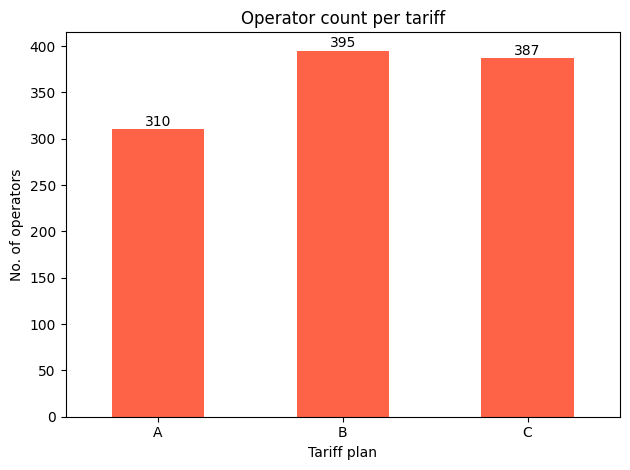

In [78]:
# Número de operadores por cliente

ops_per_client = df_merged.groupby('tariff_plan').agg(no_ops = ('operator_id', 'nunique'))

ops_per_client.plot(kind='bar',legend=False, rot=0, color='tomato')

for idx, value in enumerate(ops_per_client['no_ops']):
    plt.text(idx, value + 0.5, str(value), ha='center', va='bottom')

plt.title('Operator count per tariff')
plt.xlabel('Tariff plan')
plt.ylabel('No. of operators')
plt.tight_layout()
plt.show()

    - Curiosamente, aunque el plan C es el más popular, el plan B tiene más operadores activos.

In [79]:
df_merged['tariff_plan'].value_counts()

tariff_plan
C    16329
B    15910
A    13431
Name: count, dtype: int64

    - Contamos con cantidades similares de datos de llamadas para cada plan tarifario.

------ Tarifa A ------
  direction  count
0       out   9645
1        in   3786
Proporción de llamadas entrantes vs salientes: 0.39%
------ Tarifa B ------
  direction  count
0       out  11323
1        in   4587
Proporción de llamadas entrantes vs salientes: 0.41%
------ Tarifa C ------
  direction  count
0       out  10749
1        in   5580
Proporción de llamadas entrantes vs salientes: 0.52%


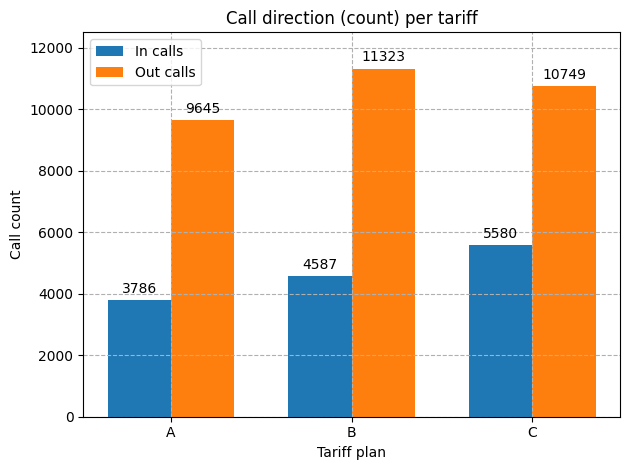

In [80]:
titulos = ['Tarifa A', 'Tarifa B','Tarifa C']
df_group = [df_merged_A, df_merged_B, df_merged_C]

llamadas_in = []
llamadas_out = []

for name, df in zip(titulos, df_group):
    print(f'------ {name} ------')
    
    resumen = df['direction'].value_counts().reset_index()
    resumen.columns = ['direction', 'count']
    print(resumen)
    
    prop = resumen.loc[resumen['direction'] == 'in', 'count'].values[0] / resumen.loc[resumen['direction'] == 'out', 'count'].values[0]
    print(f'Proporción de llamadas entrantes vs salientes: {prop:.2f}%')
    
    llamadas_in.append(resumen.loc[resumen['direction'] == 'in', 'count'].values[0])
    llamadas_out.append(resumen.loc[resumen['direction'] == 'out', 'count'].values[0])

x = np.arange(len(titulos))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, llamadas_in, width, label='In calls')
bars2 = ax.bar(x + width/2, llamadas_out, width, label='Out calls')

ax.bar_label(bars1, padding=3)
ax.bar_label(bars2, padding=3)

ax.set_ylabel('Call count')
ax.set_title('Call direction (count) per tariff')
ax.set_xticks(x)
ax.set_xticklabels(['A','B','C'])
ax.legend()

plt.xlabel('Tariff plan')
plt.grid(linestyle='--')
plt.tight_layout()
plt.ylim([0,12500])
plt.show()

    - Podríamos empezar a considerar que el plan C está pensado más para quizá un servicio de atención a clientes, quienes deben recibir llamadas constantemente.

In [81]:
df_merged_A['user_id'].nunique()

32

In [82]:
df_merged_B['user_id'].nunique()

101

In [83]:
df_merged_C['user_id'].nunique()

157

    - Con esto último, vemos diferencias entre el número de clientes en el dataframe de clientes vs el dataframe de llamadas.
    - Podemos observar que en nuestro dataframe de llamadas solamente vemos el número de clientes por tarifa expuesto arriba.

In [84]:
# Llamadas perdidas por cliente

for dataframe, nombre in zip(df_group, titulos):

    print("-----------------")
    total_calls = dataframe['calls_count'].sum()
    missed = dataframe['is_missed_call'].sum()
    prop_missed = missed / total_calls
    print(f"Total de llamadas para {nombre}:", total_calls)
    print(f"Llamadas perdidas para {nombre}:", missed)
    print(f"Proporción de llamadas perdidas para {nombre}: {prop_missed:.2f}", )
    print("\n")

-----------------
Total de llamadas para Tarifa A: 420541
Llamadas perdidas para Tarifa A: 4748
Proporción de llamadas perdidas para Tarifa A: 0.01


-----------------
Total de llamadas para Tarifa B: 152356
Llamadas perdidas para Tarifa B: 5444
Proporción de llamadas perdidas para Tarifa B: 0.04


-----------------
Total de llamadas para Tarifa C: 200077
Llamadas perdidas para Tarifa C: 5325
Proporción de llamadas perdidas para Tarifa C: 0.03




    - En la tarifa B tenemos mayor proporción de llamadas perdidas vs llamadas totales

- Llamadas internas por tarifa

In [85]:
for dataframe, nombre in zip(df_group, titulos):

    print("-----------------")
    total_calls = dataframe['calls_count'].sum()
    internal = dataframe['internal'].sum()
    prop_internal = internal / total_calls
    print(f"Total de llamadas para {nombre}:", total_calls)
    print(f"Llamadas internas para {nombre}:", internal)
    print(f"Proporción de llamadas internas para {nombre}: {prop_internal:.3f}", )
    print("\n")

-----------------
Total de llamadas para Tarifa A: 420541
Llamadas internas para Tarifa A: 2138
Proporción de llamadas internas para Tarifa A: 0.005


-----------------
Total de llamadas para Tarifa B: 152356
Llamadas internas para Tarifa B: 1643
Proporción de llamadas internas para Tarifa B: 0.011


-----------------
Total de llamadas para Tarifa C: 200077
Llamadas internas para Tarifa C: 2028
Proporción de llamadas internas para Tarifa C: 0.010




- Considero que lo ideal sería tratar el desempeño de los trabajadores según al cliente (tarifa) al que presten servicios, por esta variabilidad en la cantidad de llamadas entrantes y salientes
- Por ello realizaremos 3 métricas para decidir qué se considera como un mal colaborador, según al esquema tarifario que pertenezca.

### Tarifa A

- Punto 1: - Tiene muchas llamadas entrantes perdidas (internas y externas).

In [86]:
# Tarifa A

df_merged_A_in = df_merged_A[df_merged_A['direction'] == "in"]
df_A1 = df_merged_A_in.groupby('operator_id').agg(total_calls = ('calls_count','sum'), missed = ('is_missed_call','sum'))
df_A1['prop_missed'] = (df_A1['missed'] / df_A1['total_calls']).round(3)

df_A1.describe()

,total_calls,missed,prop_missed
count,186.000000,186.000000,186.000000
mean,189.774194,1.569892,0.009548
std,450.227885,3.349539,0.022118
min,1.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,29.000000,0.000000,0.000000
75%,144.750000,1.750000,0.010750
max,4110.000000,22.000000,0.167000


    - Podemos observar que en el 25% de datos restantes tenemos diferencias significativas en la proporción de llamadas de espera. Intentaremos reducir ese número para saber qué porcentaje está cayendo en la categoría de "operador ineficiente".

In [87]:
np.percentile(df_A1['prop_missed'], [75, 80, 95])

array([0.01075, 0.015  , 0.04375])

    - Parece ser que para el grupo de la tarifa A, considerar el 20% de operadores que están con más proporción de llamadas perdidas, es un buen dato por tomar.

In [88]:
df_A1[df_A1['prop_missed'] >= df_A1['prop_missed'].quantile(1-0.2)].reset_index()

,operator_id,total_calls,missed,prop_missed
0,885876,1152,21,0.018
1,885890,1363,22,0.016
2,888532,12,2,0.167
3,888534,61,2,0.033
4,896538,14,1,0.071
5,906392,19,2,0.105
6,906396,128,3,0.023
7,906400,143,5,0.035
8,906408,264,4,0.015
9,906410,244,6,0.025


- Punto 2: Tiene mucho tiempo de espera en llamadas entrantes.

In [89]:
# Tarifa A

df_A2 = df_merged_A_in[df_merged_A_in['is_missed_call'] == False]
df_A2 = df_A2.groupby('operator_id').agg(avg_waiting_time = ('avg_waiting_time','mean')).reset_index()

df_A2.describe()

,operator_id,avg_waiting_time
count,186.000000,186.000000
mean,927398.225806,17.127892
std,20079.803891,13.609039
min,884294.000000,0.663704
25%,911292.500000,8.582278
50%,937746.000000,13.381944
75%,940554.500000,21.719000
max,968520.000000,100.000000


    - Encontramos un pico de tiempo promedio de espera a partir del 75% de los datos, pasando de 21 a 100 en una pequeña porción de todo el dataset. Averiguaremos más al respecto.

In [90]:
np.percentile(df_A2['avg_waiting_time'], [75,80,90])

array([21.719     , 24.171     , 34.10269231])

    - Considero que si tomáramos el 25% de operadores con mayor tiempo de espera, es un buen valor para determinar que están siendo poco eficientes.

- Punto 3: Tiene pocas llamadas salientes (si debe hacerlas).

In [91]:
# Tarifa A

df_A3 = df_merged_A[df_merged_A['direction'] == "out"]

df_A3 = df_A3.groupby('operator_id').agg(out_calls = ('calls_count', 'sum')).reset_index()

df_A3.describe()

,operator_id,out_calls
count,278.000000,278.000000
mean,930237.669065,1385.766187
std,17711.723486,5744.335441
min,885876.000000,1.000000
25%,919303.000000,23.500000
50%,937751.000000,225.000000
75%,945224.000000,1320.750000
max,966686.000000,64897.000000


    - Me da la impresión que escala muy rápido la medida de llamadas salientes para este grupo tarifario, hay mucha variación en los valores. Investigamos más al respecto.

In [92]:
np.percentile(df_A3['out_calls'], [40, 50, 60])

array([ 93. , 225. , 553.2])

    - Del 40 al 60% de los datos hay bastante cambio en la cantidad de llamadas, me quedaré con el 40% de menos llamadas realizadas.

### Tarifa B

- Punto 1: - Tiene muchas llamadas entrantes perdidas (internas y externas).

In [93]:
# Tarifa B

df_merged_B_in = df_merged_B[df_merged_B['direction'] == "in"]
df_B1 = df_merged_B_in.groupby('operator_id').agg(total_calls = ('calls_count','sum'), missed = ('is_missed_call','sum'))
df_B1['prop_missed'] = (df_B1['missed'] / df_B1['total_calls']).round(3)

df_B1.describe()

,total_calls,missed,prop_missed
count,276.000000,276.000000,276.000000
mean,112.735507,0.913043,0.015083
std,404.984075,2.943043,0.049341
min,1.000000,0.000000,0.000000
25%,3.750000,0.000000,0.000000
50%,13.000000,0.000000,0.000000
75%,62.000000,1.000000,0.004000
max,5221.000000,29.000000,0.500000


    - Acá parece ser que son pocos los operadores que destacan en este dataset de llamadas perdidas, buscaremos cuál valor es el ideal de extracción de datos.

In [94]:
np.percentile(df_B1['prop_missed'], [75, 85, 90])

array([0.004 , 0.0165, 0.043 ])

    - A mi parecer, podemos quedarnos con el 15% de los datos y tendríamos un buen criterio de personal ineficiente.

- Punto 2: Tiene mucho tiempo de espera en llamadas entrantes.

In [95]:
# Tarifa B

df_B2 = df_merged_B_in[df_merged_B_in['is_missed_call'] == False]
df_B2 = df_B2.groupby('operator_id').agg(avg_waiting_time = ('avg_waiting_time','mean')).reset_index()

df_B2.describe()

,operator_id,avg_waiting_time
count,276.000000,276.000000
mean,922526.789855,19.128376
std,24356.952593,13.285693
min,879896.000000,1.000000
25%,900999.000000,10.550735
50%,920727.000000,15.432940
75%,939850.500000,23.892734
max,973286.000000,115.500000


    - Nuevamente encontramos un cambio drástico en el último 25% de los datos, reduzcamos hasta tener el porcentaje ideal.

In [96]:
np.percentile(df_B2['avg_waiting_time'], [85, 90, 99])

array([32.63147059, 35.99204545, 62.5       ])

    - Para este inciso, podría quizá quedarme con el 10% de los operadores con mayor espera en llamadas.

- Punto 3: Tiene pocas llamadas salientes (si debe hacerlas).

In [97]:
# Tarifa B

df_B3 = df_merged_B[df_merged_B['direction'] == "out"]

df_B3 = df_B3.groupby('operator_id').agg(out_calls = ('calls_count', 'sum')).reset_index()

df_B3.describe()

,operator_id,out_calls
count,329.000000,329.000000
mean,922587.501520,368.513678
std,25149.180635,784.265324
min,879896.000000,1.000000
25%,900792.000000,11.000000
50%,920706.000000,76.000000
75%,941628.000000,311.000000
max,972412.000000,7856.000000


    - A partir de la mitad de los datos encontramos variaciones altas, veamos más a detalle.

In [98]:
np.percentile(df_B3['out_calls'], [40, 55, 65])

array([ 33. , 100.8, 180.6])

    - Creo que el 55% de los operadores con menor cantidad de llamadas de salida podría funcionar para esta tarifa.

### Tarifa C

- Punto 1: - Tiene muchas llamadas entrantes perdidas (internas y externas).

In [99]:
# Tarifa C

df_merged_C_in = df_merged_C[df_merged_C['direction'] == "in"]
df_C1 = df_merged_C_in.groupby('operator_id').agg(total_calls = ('calls_count','sum'), missed = ('is_missed_call','sum')).reset_index()
df_C1['prop_missed'] = (df_C1['missed'] / df_C1['total_calls']).round(3)

df_C1.describe()

,operator_id,total_calls,missed,prop_missed
count,292.000000,292.000000,292.000000,292.000000
mean,922464.568493,127.458904,0.681507,0.015476
std,22328.886837,339.534594,1.561324,0.071098
min,882476.000000,1.000000,0.000000,0.000000
25%,904015.500000,4.000000,0.000000,0.000000
50%,921205.000000,19.000000,0.000000,0.000000
75%,939687.500000,81.000000,1.000000,0.005000
max,972460.000000,2632.000000,11.000000,1.000000


    - Nuevamente encontramos poca variación en los valores del top 25% del dataset.

In [100]:
np.percentile(df_C1['prop_missed'], [80, 90, 95])

array([0.0068, 0.03  , 0.0659])

    - Me quedaré con el 10% de operadores para este punto.

- Punto 2: Tiene mucho tiempo de espera en llamadas entrantes.

In [101]:
# Tarifa C

df_C2 = df_merged_C_in[df_merged_C_in['is_missed_call'] == False]
df_C2 = df_C2.groupby('operator_id').agg(avg_waiting_time = ('avg_waiting_time','mean')).reset_index()

df_C2.describe()

,operator_id,avg_waiting_time
count,291.000000,291.000000
mean,922374.219931,16.551936
std,22313.821970,9.985940
min,882476.000000,0.750000
25%,904015.000000,9.261909
50%,921104.000000,14.750000
75%,939448.000000,21.669754
max,972460.000000,56.333333


    - Parecería ser que aquí no hay tanto tiempo de espera en las llamadas entrantes.

In [102]:
np.percentile(df_C2['avg_waiting_time'], [80, 90, 95])

array([23.53125   , 27.76676471, 38.48315789])

    - Considerando que el promedio está alrededor de 16, me quedaré únicamente con el 10% de los datos, aunque este punto en particular me parece poco decisivo para los operadores ineficientes.

- Punto 3: Tiene pocas llamadas salientes (si debe hacerlas).

In [103]:
# Tarifa C

df_C3 = df_merged_C[df_merged_C['direction'] == "out"]

df_C3 = df_C3.groupby('operator_id').agg(out_calls = ('calls_count', 'sum')).reset_index()

df_C3.describe()

,operator_id,out_calls
count,275.000000,275.000000
mean,924702.894545,592.214545
std,23934.388055,1811.385434
min,882478.000000,1.000000
25%,903315.000000,10.000000
50%,922474.000000,68.000000
75%,944647.000000,489.500000
max,973120.000000,24572.000000


In [104]:
np.percentile(df_C3['out_calls'], [60, 70, 80])

array([191.4, 352.8, 736.4])

    - Para este inciso, nos quedaremos con el 60% de los datos de los operadores con menor número de llamadas salientes.

**RESUMEN DE PORCENTAJES POR TARIFA:**

- Tarifa A:
    - Punto 1: 20% del top
    - Punto 2: 25% del top
    - Punto 3: 40% del bot
 - Tarifa B:
    - Punto 1: 15% del top
    - Punto 2: 10% del top
    - Punto 3: 55% del bot
- Tarifa C:
    - Punto 1: 10% del top
    - Punto 2: 10% del top
    - Punto 3: 60% del bot

### Operadores sospechosos

In [105]:
# Función para que nos entreguen los operadores sospechosos según su desempeño y nuestro umbral

suspicious = []

def suspiciousOperator (df1, df2, df3, percentile_list):
    
    top_perdidas = df1[df1['prop_missed'] >= df1['prop_missed'].quantile(1-percentile_list[0])].reset_index()
    top_espera = df2[df2['avg_waiting_time'] >= df2['avg_waiting_time'].quantile(1-percentile_list[1])].reset_index()

    bottom_salientes = df3[df3['out_calls'] <= df3['out_calls'].quantile(percentile_list[2])].reset_index()

    ops_perdidas = set(top_perdidas['operator_id'])
    ops_espera = set(top_espera['operator_id'])
    ops_salientes = set(bottom_salientes['operator_id'])

    ops_sospechosos = list(ops_perdidas & ops_espera & ops_salientes)

    suspicious.append(ops_sospechosos)

    return ops_sospechosos

percentileA = [0.2, 0.25, 0.4]
percentileB = [0.15, 0.1, 0.55]
percentileC = [0.1, 0.1, 0.6]

print('Operadores sospechosos para la tarifa A:', suspiciousOperator(df_A1,df_A2,df_A3, percentileA))
print('Operadores sospechosos para la tarifa B:', suspiciousOperator(df_B1,df_B2,df_B3, percentileB))
print('Operadores sospechosos para la tarifa C:', suspiciousOperator(df_C1,df_C2,df_C3, percentileC))

Operadores sospechosos para la tarifa A: [924928, 906410]
Operadores sospechosos para la tarifa B: [920902]
Operadores sospechosos para la tarifa C: [888406]


In [106]:
# Juntamos todos los operadores en una lista y luego hacemos un dataframe de solamente ellos.

suspicious_list = sum(suspicious, [])

df_suspicious = df_merged[df_merged['operator_id'].isin(suspicious_list)]

In [107]:
# Punto 1: Llamadas entrantes perdidas (internas y externas)

df_sus_p1 = df_suspicious[df_suspicious['direction'] == 'in']
df_sus_p1 = df_sus_p1.groupby('operator_id').agg(total_calls = ('calls_count','sum'), missed = ('is_missed_call','sum'))
df_sus_p1['prop_miss'] = (df_sus_p1['missed'] / df_sus_p1['total_calls']).round(2)
df_sus_p1 = df_sus_p1.drop(columns=['total_calls', 'missed'])

# Punto 2: Tiene mucho tiempo de espera en llamadas entrantes

df_sus_p2 = df_suspicious[(df_suspicious['is_missed_call'] == False) & (df_suspicious['direction'] == 'in')]
df_sus_p2 = df_sus_p2.groupby('operator_id').agg(avg_waiting_time = ('avg_waiting_time','mean')).reset_index()

# Punto 3: Tiene pocas llamadas salientes

df_sus_p3 = df_suspicious[df_suspicious['direction'] == "out"]
df_sus_p3 = df_sus_p3.groupby('operator_id').agg(out_calls = ('calls_count', 'sum')).reset_index()

# Total de llamadas

total_calls_sus = df_suspicious.groupby('operator_id').agg(total_calls = ('calls_count','sum'))

# Merge de todos los dataframes

df_sus_report = df_sus_p1.merge(df_sus_p2, on='operator_id').merge(df_sus_p3, on='operator_id').merge(total_calls_sus, on='operator_id')

df_sus_report


,operator_id,prop_miss,avg_waiting_time,out_calls,total_calls
0,888406,0.11,32.000000,6,15
1,906410,0.02,25.400667,21,265
2,920902,0.02,48.178621,21,80
3,924928,0.03,42.867500,59,92


### Visualizaciones de operadores sospechosos

- Proporción de llamadas entrantes vs salientes

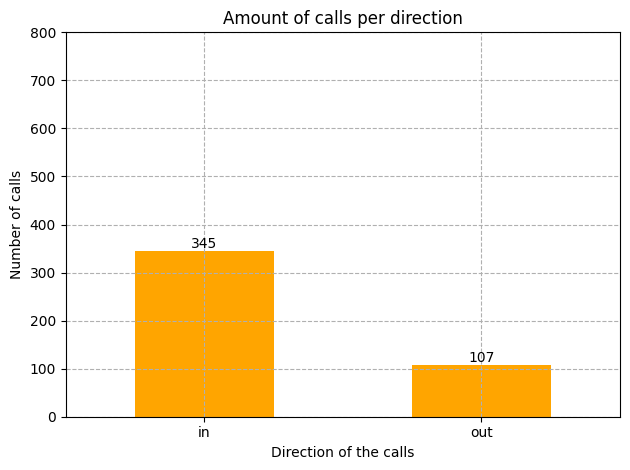

In [108]:
# Comparacion de llamadas entrantes vs salientes

bar_inout_sus = df_suspicious.groupby('direction').agg(no_calls = ('calls_count', 'sum'))

bar_inout_sus.plot(kind='bar', rot=0, legend=False, color='orange')

for idx, value in enumerate(bar_inout_sus['no_calls']):
    plt.text(idx, value + 0.5, str(value), ha='center', va='bottom')

plt.ylabel('Number of calls')
plt.xlabel('Direction of the calls')
plt.title('Amount of calls per direction')
plt.ylim(0,800)
plt.tight_layout()
plt.grid(linestyle='--')
plt.show()

In [109]:
# Proporcion de llamadas entrantes vs salientes

in_sus = df_suspicious.query('direction == "in"')['calls_count'].sum() 
out_sus = df_suspicious.query('direction == "out"')['calls_count'].sum()

prop_sus = in_sus / out_sus


print("Proporción entrantes vs salientes (operadores sospechosos):", prop_sus)

Proporción entrantes vs salientes (operadores sospechosos): 3.2242990654205608


    - En nuestras métricas anteriores, la proporción de llamadas entrantes vs salientes iban del 40% al 50%, mientras que aquí suben a incluso más del 320%.

- Promedio de llamadas (cualquiera) a lo largo del tiempo

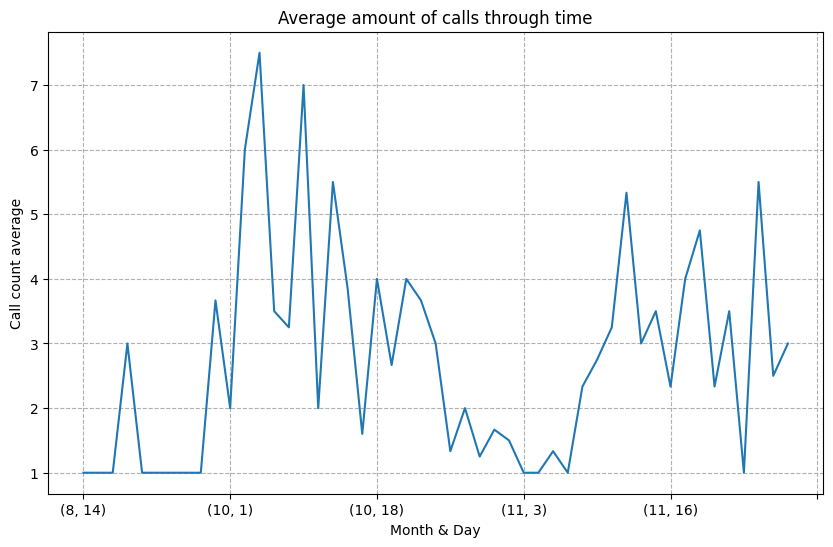

In [110]:
# Rendimiento de llamadas (cualquiera) a lo largo del tiempo

df_suspicious.groupby(['month','day']).agg(avg_no_calls = ('calls_count','mean')).plot(kind='line', legend=False, figsize=[10,6])

plt.ylabel('Call count average')
plt.xlabel('Month & Day')
plt.title('Average amount of calls through time')
plt.grid(linestyle='--')
plt.show()

    - Que entre tantos operadores, el promedio de llamadas diarias no pase de 8; parece alarmante.

- Llamadas perdidas para operadores sospechosos

In [111]:
# Proporcion de llamadas perdidas

sus_missed_calls = df_suspicious['is_missed_call'].sum()
sus_total_calls = df_suspicious['calls_count'].sum()
sus_prop_calls = (sus_missed_calls / sus_total_calls).round(2)

print("Proporción de llamadas perdidas:",sus_prop_calls)

Proporción de llamadas perdidas: 0.07


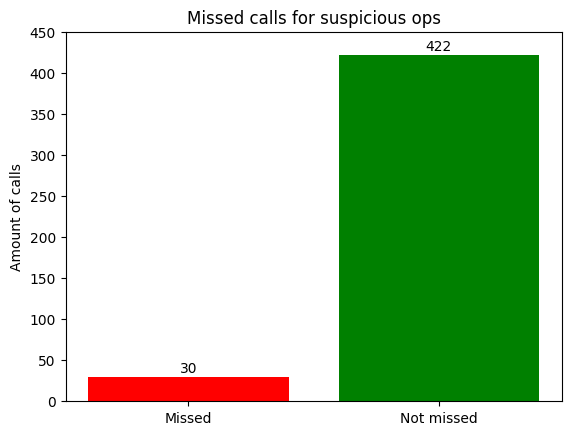

In [112]:
labels = ['Missed','Not missed']
values = [sus_missed_calls, sus_total_calls - sus_missed_calls]

plt.bar(labels, values, color=['red','green'])

plt.title('Missed calls for suspicious ops')
plt.ylabel('Amount of calls')

for i, v in enumerate(values):
    plt.text(i, v + 5, str(v), ha='center')

plt.ylim([0,450])
plt.show()

    - A pesar de ser pocos operadores, encontramos que ya superan en proporción de llamadas perdidas vs llamadas totales a las métricas de los 3 grupos tarifarios con un 7% de llamadas perdidas.

- Proporción de llamadas internas de operadores sospechosos

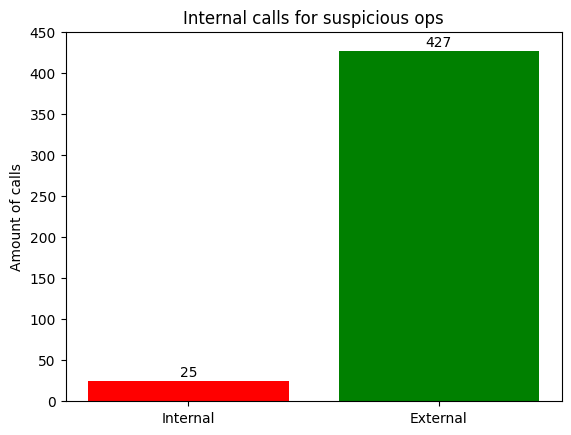

In [113]:
sus_internal_calls = df_suspicious['internal'].sum()

labels2 = ['Internal','External']
values2 = [sus_internal_calls, sus_total_calls - sus_internal_calls]

plt.bar(labels2, values2, color=['red','green'])

plt.title('Internal calls for suspicious ops')
plt.ylabel('Amount of calls')

for i, v in enumerate(values2):
    plt.text(i, v + 5, str(v), ha='center')

plt.ylim([0,450])
plt.show()

In [114]:
sus_internal_prop = sus_internal_calls / sus_total_calls

print(f'Proporción de llamadas internas vs externas: {sus_internal_prop}')

Proporción de llamadas internas vs externas: 0.05530973451327434


    - A pesar de ser pocos operadores, rápidamente con las gráficas podemos ver que tienen una proporción de llamadas internas mayor que el resto de tarifas.

- Promedio de tiempo de espera en las llamadas.

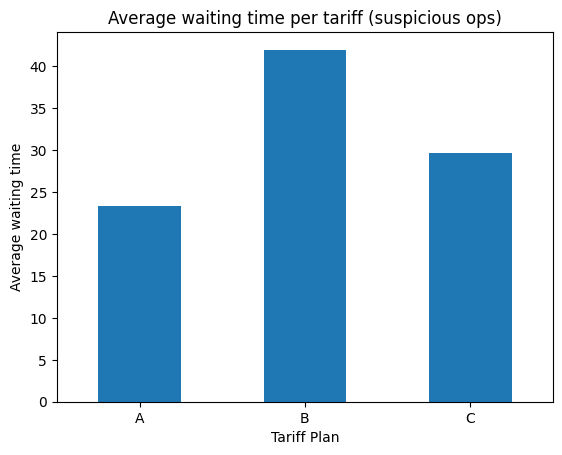

In [126]:
df_suspicious_waiting = df_suspicious.groupby('tariff_plan').agg(avg_waiting = ('avg_waiting_time','mean'))

df_suspicious_waiting.plot(kind='bar', rot=0, xlabel='Tariff Plan', ylabel='Average waiting time', title='Average waiting time per tariff (suspicious ops)', legend=False)

plt.show()

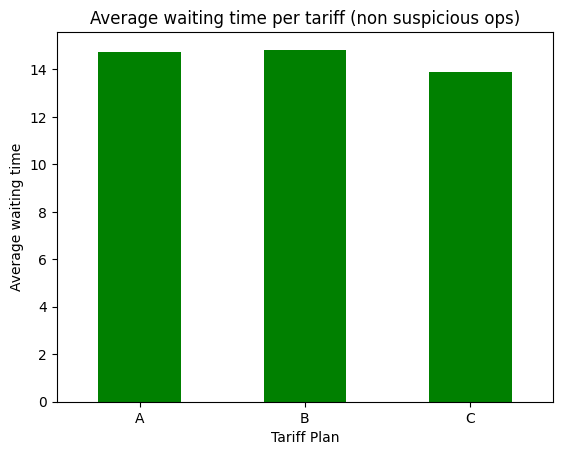

In [128]:
# Mismo gráfico pero con datos de los demás operadores (no sospechosos)

df_not_suspicious = df_merged[~df_merged['operator_id'].isin(suspicious_list)]

df_not_suspicious.groupby('tariff_plan').agg(avg_waiting = ('avg_waiting_time','mean')).plot(kind='bar', rot=0, xlabel='Tariff Plan', ylabel='Average waiting time', title='Average waiting time per tariff (non suspicious ops)', legend=False, color='green')

plt.show()

## Pruebas de hipótesis

In [117]:
# Funcion para las proporciones (Ztest)

alpha = 0.1

def propTest(countA, countO, totalA, totalO, altern='two-sided'):
    count = [countA, countO]
    nobs = [totalA, totalO]

    stat, pval = proportions_ztest(count, nobs, alternative=altern)

    if pval < alpha:
        return (f"Rechazamos hipótesis nula. Estadistico Z: {stat}, p-val: {pval}")
    else:
        return (f"No podemos rechazar hipótesis nula. Estadistico Z: {stat}, p-val: {pval}")

In [118]:
# Definimos variables para las pruebas

not_sus_total_calls = df_not_suspicious['calls_count'].sum()
not_sus_missed_calls = df_not_suspicious['is_missed_call'].sum()
not_sus_internal_calls = df_not_suspicious['internal'].sum()

#### Proporción de llamadas internas.

- Ho = La proporcion de llamadas internas no varía o es menor entre los operadores sospechosos y los operadores regulares.
- Ha = La proporcion de llamadas internas es mayor entre los operadores sospechosos.

In [119]:
propTest(sus_internal_calls, not_sus_internal_calls, sus_total_calls, not_sus_total_calls, 'larger')

'Rechazamos hipótesis nula. Estadistico Z: 11.76914498937316, p-val: 2.8146069214725265e-32'

    - Con esto concluimos que efectivamente las llamadas internas son mucho más presentes entre nuestros operadores sospechosos. Dando así a entender que probablemente estén usando las llamadas internas para platicar entre compañeros.

#### Proporción de llamadas perdidas entre operadores sospechosos y normales

- Ho: La proporción de llamadas perdidas entre operadores sospechosos y normales no varía.
- Ha: La proporción de llamadas perdidas entre operadores sospechosos y normales, es mayor.

In [120]:
propTest(sus_missed_calls, not_sus_missed_calls, sus_total_calls, not_sus_total_calls, 'larger')

'Rechazamos hipótesis nula. Estadistico Z: 7.019943331821682, p-val: 1.1097912491906258e-12'

    - Podemos decir con certeza que la proporción de llamadas perdidas para los operadores sospechosos es mayor que el resto

#### Promedio en el tiempo de espera entre operadores sospechosos y normales

- Ho: El promedio de tiempo de espera entre operadores sospechosos y normales no varía.
- Ha: El promedio de tiempo de espera entre operadores sospechosos y normales es mayor.

In [121]:
normal_ops_avg_wait = df_not_suspicious[df_not_suspicious['is_missed_call'] == False]['avg_waiting_time']
sus_ops_avg_wait = df_suspicious[df_suspicious['is_missed_call'] == False]['avg_waiting_time']

In [122]:
# Levene para comprobar varianzas

stat, p_value = levene(normal_ops_avg_wait, sus_ops_avg_wait)

print("Estadístico:", stat)
print("p-valor:", p_value)

Estadístico: 235.88067048267504
p-valor: 4.942460077403888e-53


    - Con esto, rechazaríamos la hipótesis nula de que ambas varianzas son iguales. 

In [123]:
# Prueba t para dos muestras independientes
t_stat, p_value = ttest_ind(sus_ops_avg_wait, normal_ops_avg_wait, equal_var=False, alternative='greater')  

print("t:", t_stat)
print("p:", p_value)

if p_value < alpha:
    print("Hay diferencia significativa en el promedio de tiempo de espera entre los grupos.")
else:
    print("No hay diferencia significativa en el promedio de tiempo de espera entre los grupos.")

t: 5.482051171290669
p: 1.1802173989738182e-07
Hay diferencia significativa en el promedio de tiempo de espera entre los grupos.


    - Podemos decir con confianza que el tiempo promedio de espera es mayor en el grupo de operadores sospechosos.

## Conclusiones

- Debido a los puntos claves iniciales, los operadores de riesgo serian los que tienen los id siguientes:

    - Operadores sospechosos para la tarifa A: [924928, 906410]
    - Operadores sospechosos para la tarifa B: [920902]
    - Operadores sospechosos para la tarifa C: [888406]

- Con estos operadores valdría la pena identificar quiénes son y monitorear de cerca su desempeño en los próximos días.
- Los planes B y C tienen también la mayor cantidad de operadores telefónicos.
- Curiosamente, aunque haya menos operadores en el plan tarifario A, es donde hay más operadores sospechosos.
- El plan C es el plan más contratado por los clientes.


- Para los operadores sospechosos, quizá una recomendación podría ser retirarles las llamadas internas, para evitar que hagan mal uso de ellas al estar hablando con sus compañeros.
- Así mismo, valdría la pena realizar monitoreos constantes para asegurarse de que ni pierden llamadas ni tardan mucho en contestar las que les llegan.